<a href="https://colab.research.google.com/github/ian-shade/Autotrader-Cars-Price-Predictions-ML/blob/main/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [405]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [406]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [407]:
file_path = '/content/drive/MyDrive/Colab/adverts.csv'
df = pd.read_csv(file_path)

# 1. Data/Domain Understanding and Processing


## 1.1 Inspection

In [408]:
df.head(3)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol


In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [410]:
# MISSING VALUES AND DATA TYPES
variables = pd.DataFrame(columns=['Variable','Number of unique values','Number of nulls'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].isnull().sum()]

variables

,Variable,Number of unique values,Number of nulls
0,public_reference,402005,0
1,mileage,80634,127
2,reg_code,72,31857
3,standard_colour,22,5378
4,standard_make,110,0
5,standard_model,1168,0
6,vehicle_condition,2,0
7,year_of_registration,84,33311
8,price,30578,0
9,body_type,16,837


Correlation Analysis - Numeric Features vs Price

## 1.2 Fix obvious data quality issues and enhancments

Get Car Age

*   New Car will be 2023 to avoid Null **values**

*   Feature Engineer the Age out of year_of_registration.

*   I have assumed that the new car is 2023 model a two years higher than the latest Used car.



In [411]:
df['year_of_registration'] = df['year_of_registration'].fillna(2023) # Assumed new car as 2023
df['age'] = 2023 - df['year_of_registration'] # Assuming current year is 2022
df = df.drop('year_of_registration', axis=1) # Replaces with age

In [412]:
# Columns we can't make use off will be dropped
df = df.drop('reg_code', axis=1)
df = df.drop('standard_model', axis=1) #
df = df.drop('public_reference', axis=1)

## Target Feature Analysis

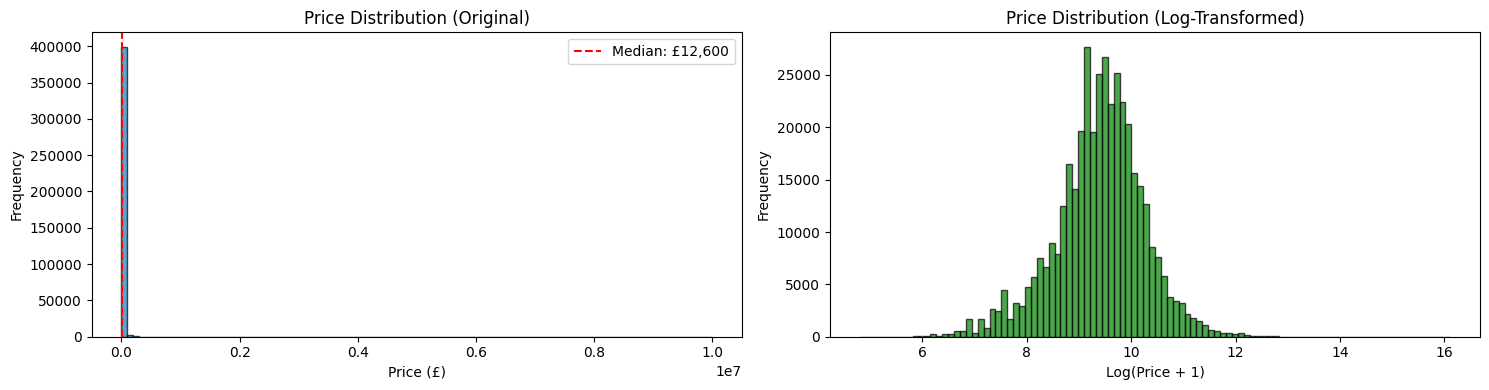


Skewness: 154.682 (high positive skew)
Kurtosis: 32182.673

**Interpretation:** Heavy right skew indicates most cars are lower-priced with
luxury outliers. Log transformation normalizes this for linear models.


In [413]:
# TARGET VARIABLE (PRICE) DISTRIBUTION

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Original price
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original)')
axes[0].axvline(df['price'].median(), color='r', linestyle='--',
                label=f'Median: £{df["price"].median():,.0f}')
axes[0].legend()

# Log-transformed
axes[1].hist(np.log1p(df['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.tight_layout()
plt.show()

print(f"\nSkewness: {df['price'].skew():.3f} (high positive skew)")
print(f"Kurtosis: {df['price'].kurtosis():.3f}")
print("\n**Interpretation:** Heavy right skew indicates most cars are lower-priced with")
print("luxury outliers. Log transformation normalizes this for linear models.")

In [414]:
price_cap = 350000   # Excludes super/luxury cars

df_clean = df[df['price'] < price_cap].copy()

# Print how much data was lost
lost_data = len(df) - len(df_clean)
print(f"Removed {lost_data} rows ({(lost_data/len(df))*100:.2f}%) as outliers.")
df = df_clean

Removed 145 rows (0.04%) as outliers.


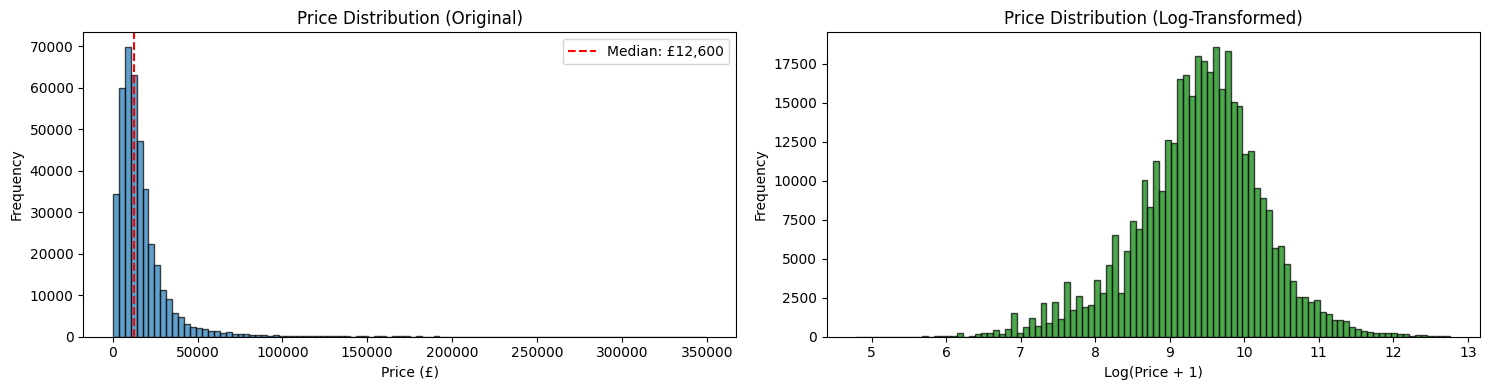

In [415]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Original price
axes[0].hist(df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price (£)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original)')
axes[0].axvline(df['price'].median(), color='r', linestyle='--',
                label=f'Median: £{df["price"].median():,.0f}')
axes[0].legend()

# Log-transformed
axes[1].hist(np.log1p(df['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-Transformed)')

plt.tight_layout()
plt.show()

## Identify Numeric Features analysis and change

***Removing Old Cars*** :

* While data points such as a 1969 Land Rover Series II were identified as valid (not noise), they were removed as outliers. These vintage vehicles follow a different valuation logic (appreciating assets) compared to the standard modern vehicle market. Including them would introduce non-linearity that could degrade the performance of the Linear Regression model.
* Any car befor 1886 is definitly noise since it is the date first car was ever made.

***Get rid of cars with high mileage*** :

* Some cars have almost wrong millage they set records more than the most driven car in the world.
* little few cars have a milage thats high (Taxis) and they can be counted but at the same time including them will be be unbenificial since taxis ads is limited espically after uber there is no need to buy a taxi to work in a cab.

In [416]:
num_feat = ['age', 'mileage']

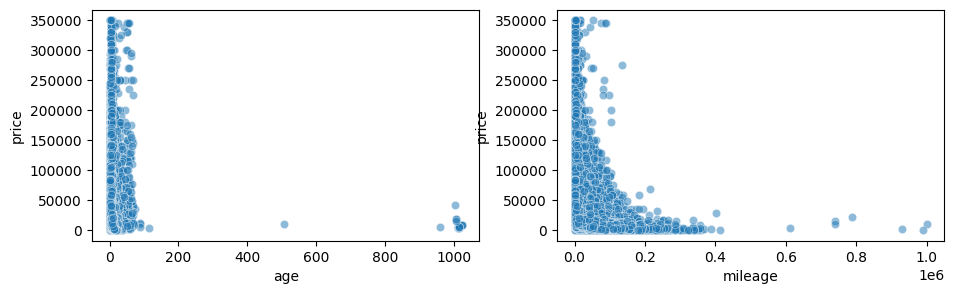

In [417]:
fig, axs = plt.subplots(nrows=1, ncols=len(num_feat), figsize=(11,3))
for i in range(len(num_feat)):
  sns.scatterplot(data=df, x=num_feat[i-1], y='price', alpha=0.5, ax=axs[i-1])

In [418]:
price_cap = 350000
mileage_cap = 300000 # Excludes taxis/errors
age_cap = 33 # Exclude vintage cars

df_clean = df[
    # (df['price'] < price_cap) &
    (df['mileage'] < mileage_cap) &
    (df['age'] <= age_cap)
].copy()

# Print how much data was lost
lost_data = len(df) - len(df_clean)
print(f"Removed {lost_data} rows ({(lost_data/len(df))*100:.2f}%) as outliers.")
df = df_clean

Removed 813 rows (0.20%) as outliers.


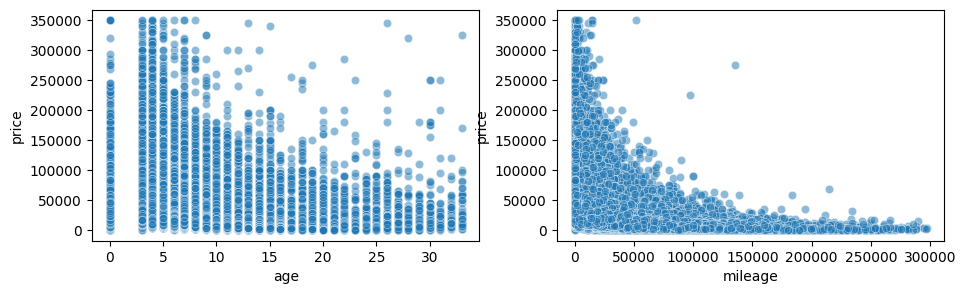

In [419]:
fig, axs = plt.subplots(nrows=1, ncols=len(num_feat), figsize=(11,3))
for i in range(len(num_feat)):
  sns.scatterplot(data=df, x=num_feat[i-1], y='price', alpha=0.5, ax=axs[i-1])

## Get new prestige Feature out of the Car standard_make

In [420]:
def get_brand_prestige_class(brand):

    prestige_map = {
        # Class 5: Exotic/Hypercar (£150k+)
        'Ferrari': 5, 'Lamborghini': 5, 'McLaren': 5, 'Bugatti': 5, 'Pagani': 5,

        # Class 4: Ultra-Luxury (£95k)
        'Bentley': 4, 'Rolls-Royce': 4, 'Maybach': 4, 'Daimler': 4, 'BAC': 4,

        # Class 3: Luxury (£40k)
        'Jaguar': 3, 'Land Rover': 3, 'Porsche': 3, 'Maserati': 3, 'Aston Martin': 3, 'Lotus': 3, 'TVR': 3,
        'Morgan': 3, 'Caterham': 3, 'Noble': 3, 'Ariel': 3, 'Alpine': 3, 'Corvette': 3, 'Hummer': 3, 'Radical': 3,
        'Ultima': 3, 'AC': 3, 'Bristol': 3, 'Jensen': 3, 'Triumph': 3,

        # Class 2: Premium/Near-Luxury (£20k)
        'Audi': 2, 'BMW': 2, 'Mercedes-Benz': 2, 'Volkswagen': 2, 'MINI': 2, 'Volvo': 2, 'Lexus': 2,
        'Alfa Romeo': 2, 'Subaru': 2, 'Infiniti': 2, 'Tesla': 2, 'Abarth': 2, 'Cadillac': 2, 'Lincoln': 2,
        'Saab': 2, 'Lancia': 2, 'Chrysler': 2, 'Buick': 2, 'Westfield': 2, 'Zenos': 2,

        # Class 1: Budget + Mass Market (£10k) - ALL OTHERS

        # Budget brands
        'Dacia': 1, 'Perodua': 1, 'Proton': 1, 'SsangYong': 1, 'Daewoo': 1, 'Great Wall': 1, 'Rover': 1,
        'MG': 1, 'Suzuki': 1, 'Daihatsu': 1, 'Datsun': 1, 'Aixam': 1, 'Reliant': 1,
        # Mass market brands
        'Vauxhall': 1, 'SKODA': 1, 'SEAT': 1, 'Peugeot': 1, 'Citroen': 1, 'Renault': 1, 'Fiat': 1, 'Kia': 1,
        'Hyundai': 1, 'Nissan': 1, 'Toyota': 1, 'Honda': 1, 'Mazda': 1, 'Mitsubishi': 1, 'Ford': 1,
        'Chevrolet': 1, 'Opel': 1, 'Smart': 1, 'DS AUTOMOBILES': 1, 'CUPRA': 1, 'Jeep': 1, 'Dodge': 1,
        'GMC': 1, 'Isuzu': 1, 'Pontiac': 1, 'Plymouth': 1, 'Holden': 1, 'International': 1,
        # Commercial/Taxi
        'London Taxis International': 1, 'LEVC': 1, 'Carbodies': 1, 'Iveco': 1,
        # Classic/Kit cars (lower value)
        'Panther': 1, 'Replica': 1, 'Custom Vehicle': 1, 'Dax': 1, 'Tiger': 1, 'Pilgrim': 1, 'Mev': 1,
        'Beauford': 1, 'Sebring': 1, 'Gentry': 1, 'AK': 1, 'Mitsuoka': 1, 'Austin': 1, 'Morris': 1,
        'Leyland': 1, 'Wolseley': 1,
    }

    return prestige_map.get(brand, 1)

In [421]:
df['brand_prestige'] = df['standard_make'].apply(get_brand_prestige_class)

In [422]:
print(df.groupby('brand_prestige')['price'].agg(['count', 'mean', 'median']).round(0))

                 count      mean    median
brand_prestige                            
1               201227   10945.0    9499.0
2               169323   18975.0   15990.0
3                27864   37029.0   29995.0
4                 1310   94477.0   79993.0
5                 1323  150807.0  144950.0


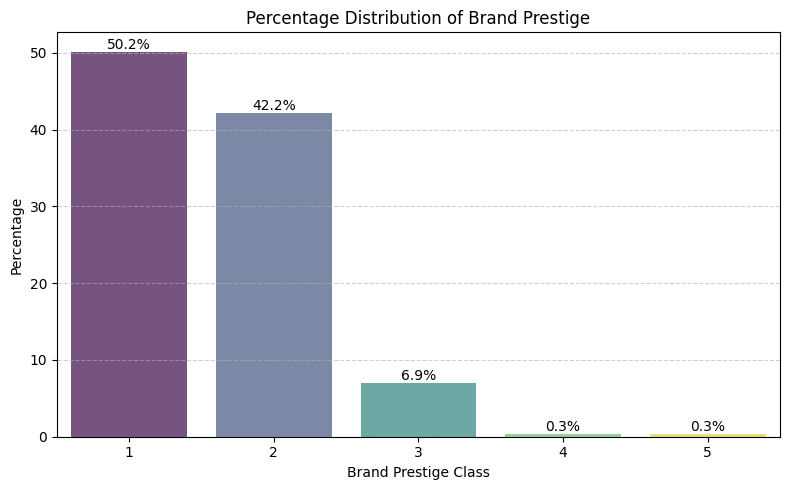

In [423]:
# 1. Percentage Distribution for brand_prestige
plt.figure(figsize=(8, 5))
percentages_prestige = df['brand_prestige'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
percentages_prestige.columns = ['brand_prestige', 'percent']
sns.barplot(data=percentages_prestige, x='brand_prestige', y='percent', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Percentage Distribution of Brand Prestige')
plt.xlabel('Brand Prestige Class')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

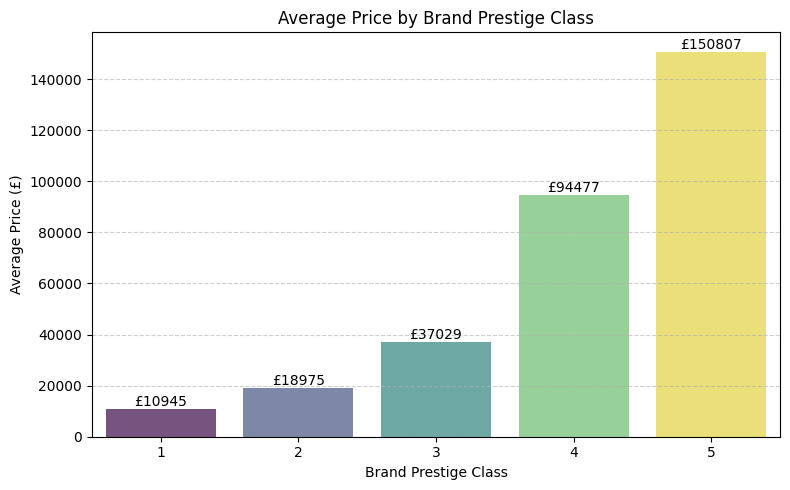

In [424]:
# 1. Average Price per Brand Prestige Class
plt.figure(figsize=(8, 5))
mean_price_prestige = df.groupby('brand_prestige')['price'].mean().reset_index()
sns.barplot(data=mean_price_prestige, x='brand_prestige', y='price', hue='brand_prestige', alpha=0.7, palette='viridis', legend=False)
plt.title('Average Price by Brand Prestige Class')
plt.xlabel('Brand Prestige Class')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=0)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='£%.0f')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Identify Categorical Features analysis and change

Minimize the dimentions on the categorical feature.


*   Currently we have allot of categorical features most of them is have very little to no real representation so we will have the top(n) feature of each feature.
*   All features that are not in the top(n) will be added under single one feature named "feature_name_other".
*   Sometimes the new (other) feature will becom more represented than other brand and thats totally fine it's called the tail effect allot of small chunks adds up if the percentage is under 60 thats totally normal espically for a feature like "standard_make".

**End results is**
1.  Keep top 20 Brands
2.  Keep top 10 Colors
3.  Keep top 8 Body Types
4.  Keep top 4 (Petrol, Diesel, Hybrid, Electric)
5. Everything that is not on top will be other

In [425]:
df['crossover_car_and_van'] = df['crossover_car_and_van'].astype(int)
df['crossover_car_and_van'].value_counts(normalize=True)

,proportion
crossover_car_and_van,
0,0.995599
1,0.004401


In [426]:
# Drop 'crossover_car_and_van' due to near-zero variance (<0.5% positive class)
df.drop(columns=['crossover_car_and_van'], inplace=True, errors='ignore')

In [427]:
categorical_feat = ['standard_colour', 'standard_make',
                    'vehicle_condition', 'body_type','fuel_type']

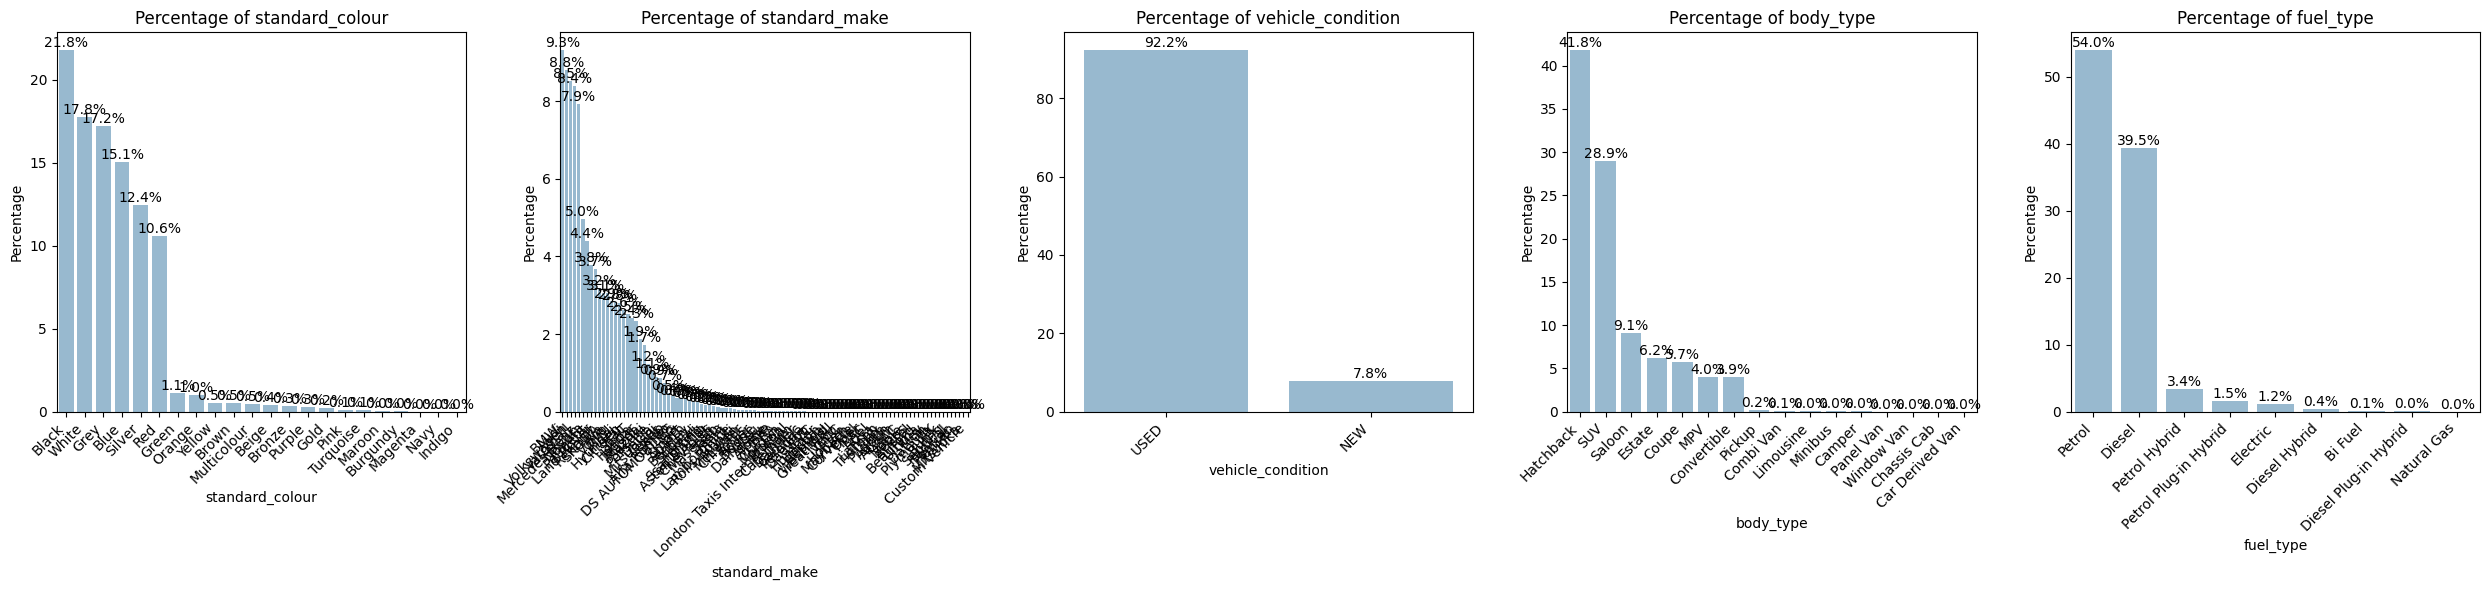

In [428]:
def printCountCategorical():
  num_cols = len(categorical_feat)
  fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(5 * num_cols, 6))
  axs = axs.flatten() # Flatten the 2D array of axes into a 1D array for easier iteration

  for i in range(len(categorical_feat)):
    # Calculate percentage for each category
    percentages = df[categorical_feat[i]].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    percentages.columns = [categorical_feat[i], 'percent'] # Rename columns for clarity

    # Create a bar plot using percentages
    sns.barplot(data=percentages, x=categorical_feat[i], y='percent', alpha=0.5, ax=axs[i])
    axs[i].set_title(f'Percentage of {categorical_feat[i]}') # Updated title
    axs[i].set_ylabel('Percentage') # Set y-axis label to Percentage
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45, ha='right') # Rotate labels

    # Add percentage labels on top of bars
    for container in axs[i].containers:
        axs[i].bar_label(container, fmt='%.1f%%')

  plt.tight_layout()
  plt.show()

# call function
printCountCategorical()

In [429]:
def clean_categorical(df, column, top_n=10):
    # Find the top N most frequent categories
    top_categories = df[column].value_counts().nlargest(top_n).index

    # Overwrite the column: keep top_n values, replace others with 'Other'
    df[column] = df[column].where(df[column].isin(top_categories), other='Other')

    print(f"Cleaned '{column}': now has {df[column].nunique()} unique categories.")

In [430]:
clean_categorical(df, 'standard_colour', top_n=10) # Keep top 10 Colors
clean_categorical(df, 'body_type', top_n=8)        # Keep top 8 Body Types
clean_categorical(df, 'fuel_type', top_n=4)        # Keep top 4 (Petrol, Diesel, Hybrid, Electric)
clean_categorical(df, 'standard_make', top_n=20)   # Keep top 20 Brands

Cleaned 'standard_colour': now has 11 unique categories.
Cleaned 'body_type': now has 9 unique categories.
Cleaned 'fuel_type': now has 5 unique categories.
Cleaned 'standard_make': now has 21 unique categories.


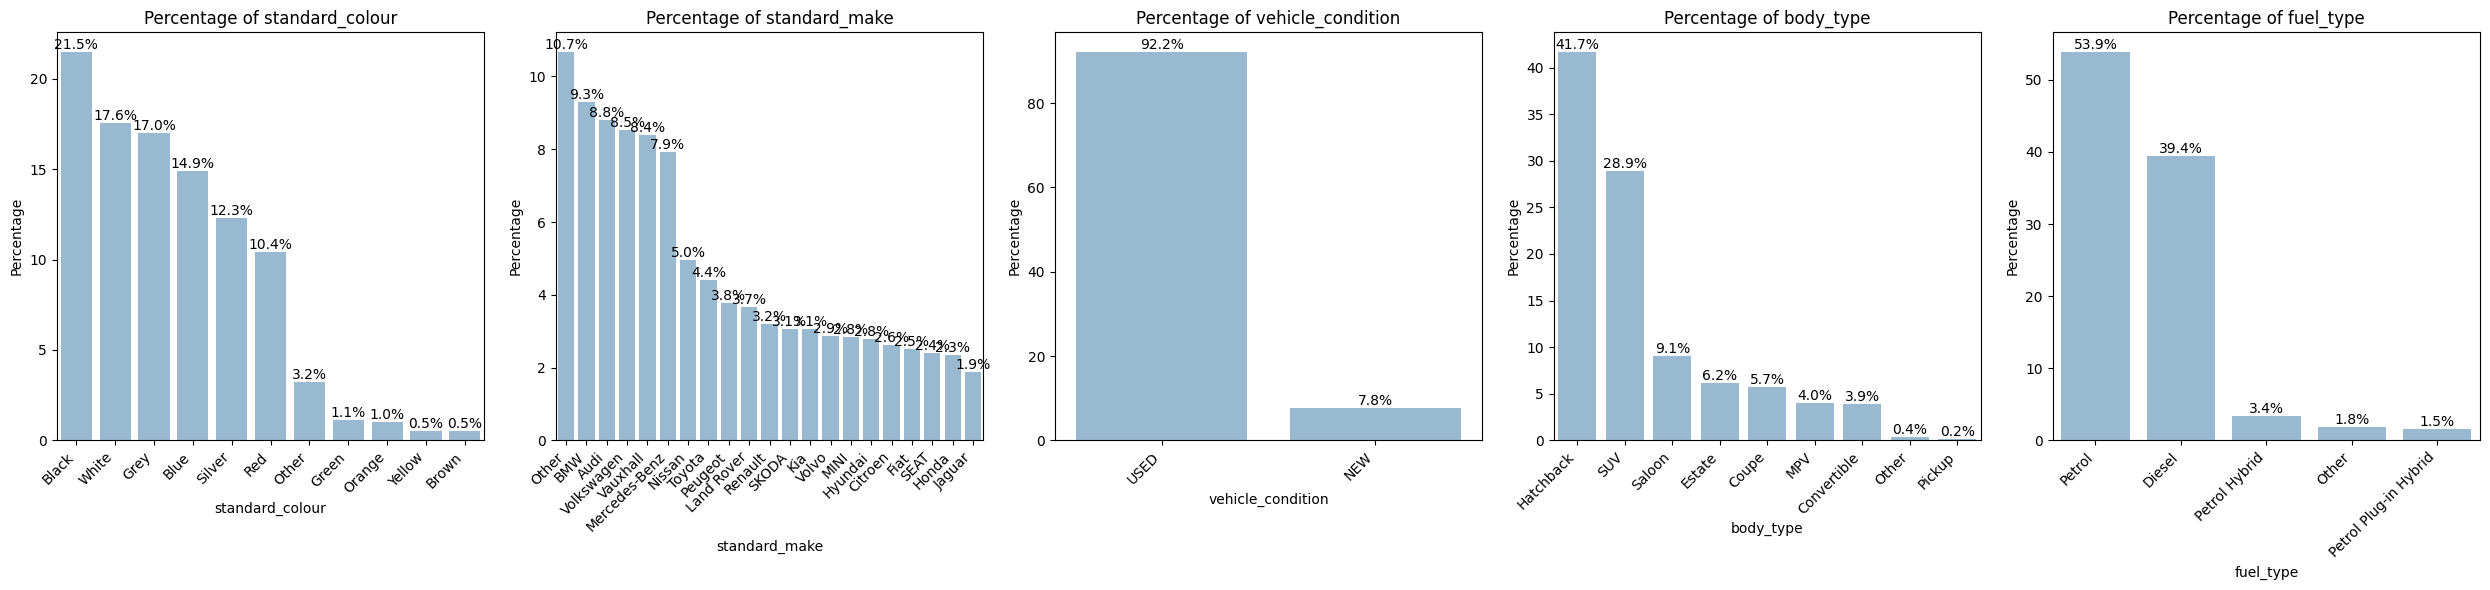

In [431]:
printCountCategorical()

# Visual Analysis of Top Numeric and Categorical Predictors

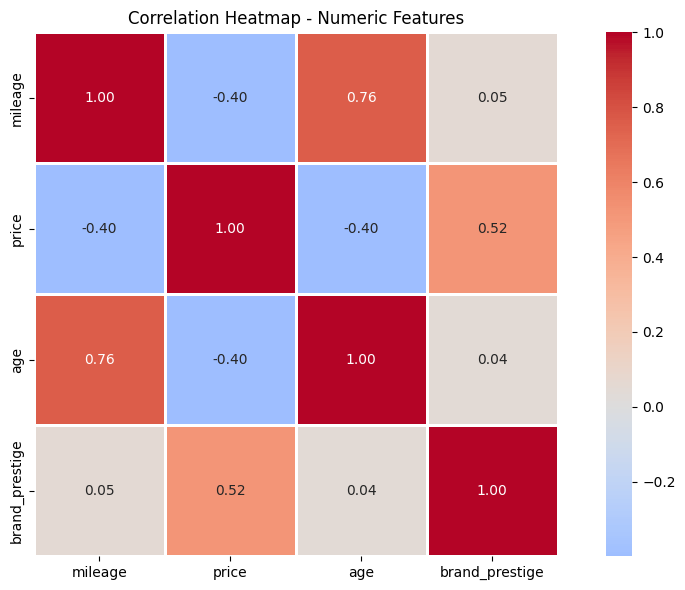


--- Correlation with Price (Target Variable) ---
price             1.000000
brand_prestige    0.516728
age              -0.396349
mileage          -0.398441
Name: price, dtype: float64


In [432]:
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

# Focus on correlation with price
price_correlation = correlation_matrix['price'].sort_values(ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap - Numeric Features')
plt.tight_layout()
plt.show()

print("\n--- Correlation with Price (Target Variable) ---")
print(price_correlation)


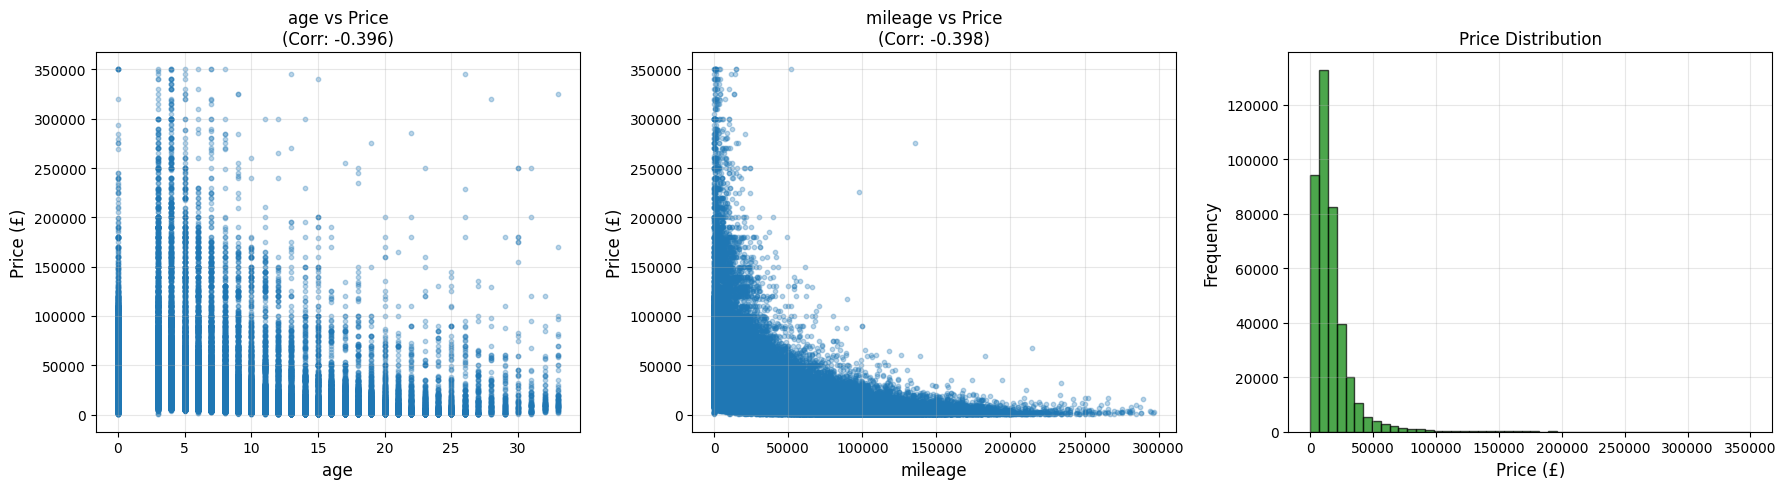

In [433]:
# EXAMPLE 2: Visual Analysis of Top Numeric Predictors
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Top 3 numeric predictors based on correlation
top_features = ['age', 'mileage', 'price']

for i, feature in enumerate(top_features[:-1]):  # Exclude price itself
    axes[i].scatter(df[feature], df['price'], alpha=0.3, s=10)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Price (£)', fontsize=12)
    axes[i].set_title(f'{feature} vs Price\n(Corr: {df[feature].corr(df["price"]):.3f})',
                      fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Add a distribution of price for context
axes[2].hist(df['price'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('Price (£)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Price Distribution', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


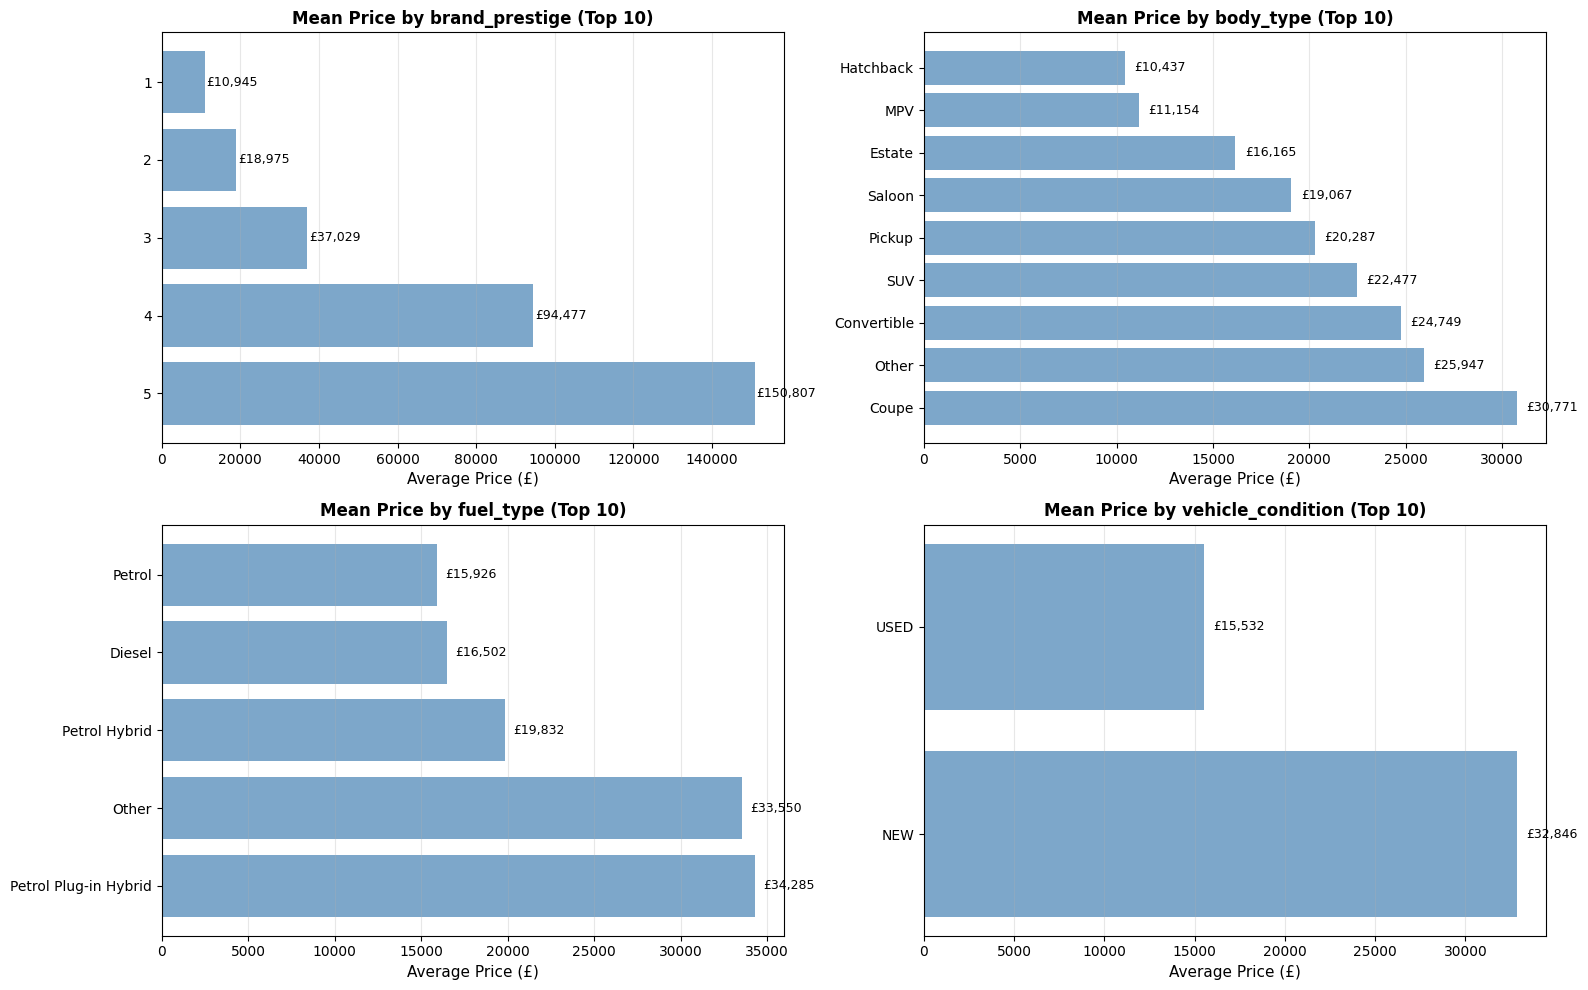


--- Predictive Power: Between-Group Variance ---
brand_prestige      : 10.7015 (higher = more predictive)
body_type           : 0.1394 (higher = more predictive)
fuel_type           : 0.2563 (higher = more predictive)
vehicle_condition   : 0.4576 (higher = more predictive)


In [434]:
# EXAMPLE 3: Categorical Features - Mean Price by Category (Predictive Power)
categorical_features = ['brand_prestige', 'body_type', 'fuel_type', 'vehicle_condition']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    # Calculate mean price per category
    feature_price = df.groupby(feature)['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)

    # Keep only top 10 categories for readability
    top_10 = feature_price.head(10)

    axes[i].barh(range(len(top_10)), top_10['mean'], color='steelblue', alpha=0.7)
    axes[i].set_yticks(range(len(top_10)))
    axes[i].set_yticklabels(top_10.index)
    axes[i].set_xlabel('Average Price (£)', fontsize=11)
    axes[i].set_title(f'Mean Price by {feature} (Top 10)', fontsize=12, fontweight='bold')
    axes[i].grid(axis='x', alpha=0.3)

    # Add value labels
    for j, v in enumerate(top_10['mean']):
        axes[i].text(v + 500, j, f'£{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Statistical measure: Variance Ratio (high = strong predictor)
print("\n--- Predictive Power: Between-Group Variance ---")
for feature in categorical_features:
    grouped = df.groupby(feature)['price']
    between_var = grouped.mean().var()  # Variance of group means
    within_var = df['price'].var()       # Total variance
    variance_ratio = between_var / within_var

    print(f"{feature:20s}: {variance_ratio:.4f} (higher = more predictive)")


# Prepare Machine Learning Models

## Hot Incoding for features

In [435]:
df.shape

(401047, 9)

In [436]:
df.keys()

Index(['mileage', 'standard_colour', 'standard_make', 'vehicle_condition',
       'price', 'body_type', 'fuel_type', 'age', 'brand_prestige'],
      dtype='object')

In [437]:
ohe = OneHotEncoder(handle_unknown='ignore')

# Encode on categorical columns
df = pd.get_dummies(data=df, dtype=int)

# Display DataFrame shape
df.shape

(401047, 52)

In [438]:
df.keys()

Index(['mileage', 'price', 'age', 'brand_prestige', 'standard_colour_Black',
       'standard_colour_Blue', 'standard_colour_Brown',
       'standard_colour_Green', 'standard_colour_Grey',
       'standard_colour_Orange', 'standard_colour_Other',
       'standard_colour_Red', 'standard_colour_Silver',
       'standard_colour_White', 'standard_colour_Yellow', 'standard_make_Audi',
       'standard_make_BMW', 'standard_make_Citroen', 'standard_make_Fiat',
       'standard_make_Honda', 'standard_make_Hyundai', 'standard_make_Jaguar',
       'standard_make_Kia', 'standard_make_Land Rover', 'standard_make_MINI',
       'standard_make_Mercedes-Benz', 'standard_make_Nissan',
       'standard_make_Other', 'standard_make_Peugeot', 'standard_make_Renault',
       'standard_make_SEAT', 'standard_make_SKODA', 'standard_make_Toyota',
       'standard_make_Vauxhall', 'standard_make_Volkswagen',
       'standard_make_Volvo', 'vehicle_condition_NEW',
       'vehicle_condition_USED', 'body_type_Convert

Avoid Multicolinearity

In [439]:
df.drop(['standard_colour_Yellow','standard_make_Renault','vehicle_condition_NEW','body_type_Convertible','fuel_type_Petrol Plug-in Hybrid'],axis=1, inplace=True)

In [440]:
df.head(3)

,mileage,price,age,brand_prestige,standard_colour_Black,standard_colour_Blue,standard_colour_Brown,standard_colour_Green,standard_colour_Grey,standard_colour_Orange,...,body_type_Hatchback,body_type_MPV,body_type_Other,body_type_Pickup,body_type_SUV,body_type_Saloon,fuel_type_Diesel,fuel_type_Other,fuel_type_Petrol,fuel_type_Petrol Hybrid
0,0.0,73970,0.0,2,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,108230.0,7000,12.0,3,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,7800.0,14000,6.0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


## Preparing The Split

In [441]:
# Take the log1p of the price
y = np.log1p(df['price'])
X = df.drop('price', axis=1)

seed = 7

In [442]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    # train_size=0.10,
    # test_size=0.02,
    test_size = 0.2,
    random_state=seed,
    stratify=df['brand_prestige'] ## TODO: figure out what is this
)

print("X_train shape: ", X_train.shape, "; y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "; y_test shape: ", y_test.shape)

X_train shape:  (320837, 46) ; y_train shape:  (320837,)
X_test shape:  (80210, 46) ; y_test shape:  (80210,)


## Scaler on train and test

In [443]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# FIT on Training data only, then TRANSFORM both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (optional, keeps column names for analysis later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

## Cross Valdation

In [444]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [445]:
models = []
models.append(('LinReg', LinearRegression()))
# models.append(('kNN', KNeighborsRegressor(n_neighbors=23, weights='distance', metric='manhattan', n_jobs=-1)))
models.append(('DT', DecisionTreeRegressor(random_state=42,min_samples_split=100,min_samples_leaf=10,max_depth=20)))

seed = 42
np.random.seed(seed)

names = []
results = []

print("Model Evaluation (R2 Score):")
print("-" * 30)

for name, model in models:
    k_fold = model_selection.KFold(n_splits=5, shuffle=True, random_state=seed)

    cv_results = model_selection.cross_val_score(
        model, X_train_scaled, y_train, cv=k_fold, scoring="r2"
    )

    results.append(cv_results)
    names.append(name)

    # Print mean score and standard deviation
    print(f"{name}: {cv_results.mean():.3f} (Std: {cv_results.std():.3f})")

Model Evaluation (R2 Score):
------------------------------
LinReg: 0.852 (Std: 0.001)
DT: 0.892 (Std: 0.001)


/tmp/ipython-input-4057337144.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results,labels=names)


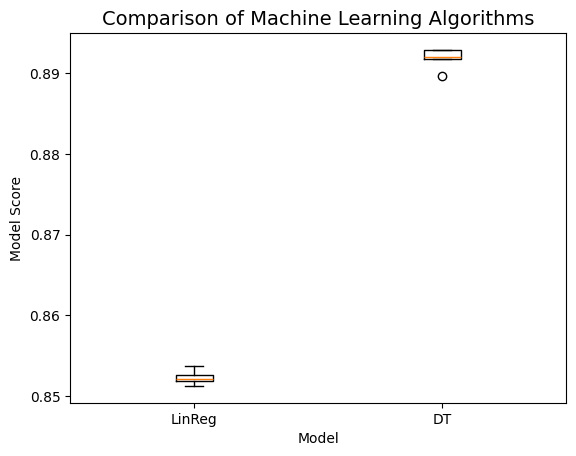

In [446]:
plt.boxplot(results,labels=names)
plt.title('Comparison of Machine Learning Algorithms',fontsize=14)
plt.gca().set(ylabel='Model Score', xlabel='Model')
plt.show()

## Models Parameters Optimaiztion will be run to get best set of parameters for each model

In [447]:
# Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# Models
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RANDOM_STATE = 42

### RIDGE REGRESSION GRID SEARCH

In [448]:
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100, 1000]
}

print(f"Parameter grid: {ridge_param_grid}")
print(f"Total configurations: {len(ridge_param_grid['alpha'])}")

ridge_grid = GridSearchCV(
    Ridge(random_state=RANDOM_STATE),
    param_grid=ridge_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

ridge_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {ridge_grid.best_params_}")
print(f"Best CV R²: {ridge_grid.best_score_:.4f}")

# Results table
results_df = pd.DataFrame(ridge_grid.cv_results_)
results = results_df[['param_alpha', 'mean_test_score', 'std_test_score']].sort_values(
    'mean_test_score', ascending=False
)
results.columns = ['Alpha', 'Mean_R2', 'Std_R2']
print("All configurations (ranked):")
print(results.to_string(index=False))

Parameter grid: {'alpha': [0.1, 1, 10, 100, 1000]}
Total configurations: 5
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'alpha': 10}
Best CV R²: 0.8523
All configurations (ranked):
 Alpha  Mean_R2   Std_R2
  10.0 0.852304 0.002205
   1.0 0.852304 0.002206
   0.1 0.852304 0.002206
 100.0 0.852303 0.002204
1000.0 0.852228 0.002189


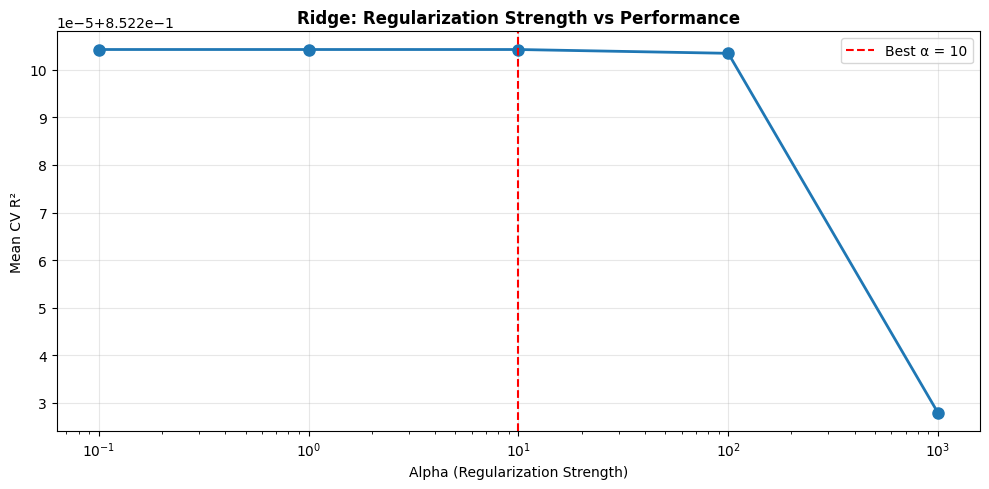


Test Set R²: 0.8534


In [449]:
# Plot
plt.figure(figsize=(10, 5))
plt.semilogx(ridge_param_grid['alpha'], results['Mean_R2'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean CV R²')
plt.title('Ridge: Regularization Strength vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.axvline(ridge_grid.best_params_['alpha'], color='red', linestyle='--',
            label=f"Best α = {ridge_grid.best_params_['alpha']}")
plt.legend()
plt.tight_layout()
plt.show()

# Test evaluation
y_pred_ridge_best = ridge_grid.best_estimator_.predict(X_test_scaled)
test_r2_ridge = r2_score(y_test, y_pred_ridge_best)
print(f"\nTest Set R²: {test_r2_ridge:.4f}")

### DECISION TREE GRID SEARCH

In [450]:
dt_param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 40]
}

print("Parameter grid:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")

total_combos = np.prod([len(v) for v in dt_param_grid.values()])
print(f"\nTotal combinations: {total_combos}")

dt_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid=dt_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)


print("Best parameters:")
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV R²: {dt_grid.best_score_:.4f}")

# Top 10 configurations
results_df = pd.DataFrame(dt_grid.cv_results_)
top10 = results_df[
    ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf',
     'mean_test_score', 'std_test_score']
].sort_values('mean_test_score', ascending=False).head(10)
top10.columns = ['Max_Depth', 'Min_Split', 'Min_Leaf', 'Mean_R2', 'Std_R2']

print("\nTop configurations:")
print(top10.to_string(index=False))

Parameter grid:
  max_depth: [5, 10, 15, 20, None]
  min_samples_split: [20, 50, 100]
  min_samples_leaf: [10, 20, 40]

Total combinations: 45
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters:
  max_depth: 20
  min_samples_leaf: 10
  min_samples_split: 50

Best CV R²: 0.8919

Top configurations:
Max_Depth  Min_Split  Min_Leaf  Mean_R2   Std_R2
       20         50        10 0.891907 0.001232
       20        100        10 0.891844 0.000976
     None        100        10 0.891532 0.000912
       20         50        20 0.891037 0.001156
     None         50        10 0.890923 0.001204
       15         50        10 0.890901 0.001185
       20         20        20 0.890745 0.001112
       20        100        20 0.890735 0.001096
     None        100        20 0.890602 0.001023
     None         50        20 0.890545 0.001137


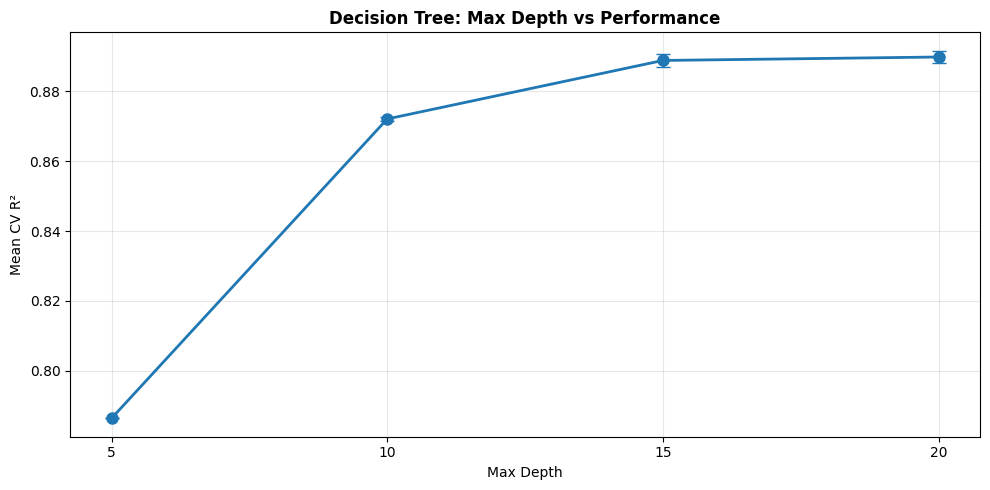


Test R²: 0.8947
Train R²: 0.9120
Overfit gap: 0.0173


In [451]:
# Depth analysis
depth_perf = results_df.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std'])

plt.figure(figsize=(10, 5))
plt.errorbar(range(len(depth_perf)), depth_perf['mean'], yerr=depth_perf['std'],
             marker='o', linewidth=2, markersize=8, capsize=5)
plt.xticks(range(len(depth_perf)), depth_perf.index)
plt.xlabel('Max Depth')
plt.ylabel('Mean CV R²')
plt.title('Decision Tree: Max Depth vs Performance', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Test evaluation
y_pred_dt_best = dt_grid.best_estimator_.predict(X_test)
test_r2_dt = r2_score(y_test, y_pred_dt_best)
train_r2_dt = dt_grid.best_estimator_.score(X_train, y_train)

print(f"\nTest R²: {test_r2_dt:.4f}")
print(f"Train R²: {train_r2_dt:.4f}")
print(f"Overfit gap: {train_r2_dt - test_r2_dt:.4f}")

### k-NN GRID SEARCH AND FINAL MODEL COMPARISON

In [452]:
# knn_param_grid = {
#     'n_neighbors': [3, 5, 7, 10],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# print("Parameter grid:")
# for param, values in knn_param_grid.items():
#     print(f"  {param}: {values}")

# total_combos = np.prod([len(v) for v in knn_param_grid.values()])
# print(f"\nTotal combinations: {total_combos}")

# knn_grid = GridSearchCV(
#     KNeighborsRegressor(),
#     param_grid=knn_param_grid,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1
# )

# print("\nRunning grid search...")
# knn_grid.fit(
#     X_train_scaled[:20000],
#     y_train[:20000]
#     )

# print("Best parameters:")
# for param, value in knn_grid.best_params_.items():
#     print(f"  {param}: {value}")
# print(f"\nBest CV R²: {knn_grid.best_score_:.4f}")

# # Top 10 configurations
# results_df = pd.DataFrame(knn_grid.cv_results_)
# top10 = results_df[
#     ['param_n_neighbors', 'param_weights', 'param_metric', 'mean_test_score', 'std_test_score']
# ].sort_values('mean_test_score', ascending=False).head(10)
# top10.columns = ['K', 'Weights', 'Metric', 'Mean_R2', 'Std_R2']

# print("\nTop 10 configurations:")
# print(top10.to_string(index=False))

In [453]:
# # k analysis
# k_perf = results_df.groupby('param_n_neighbors')['mean_test_score'].agg(['mean', 'std'])

# plt.figure(figsize=(10, 5))
# plt.errorbar(k_perf.index, k_perf['mean'], yerr=k_perf['std'],
#              marker='o', linewidth=2, markersize=8, capsize=5)
# plt.xlabel('Number of Neighbors (k)')
# plt.ylabel('Mean CV R²')
# plt.title('k-NN: Number of Neighbors vs Performance', fontweight='bold')
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()

# # Test evaluation
# y_pred_knn_best = knn_grid.best_estimator_.predict(X_test_scaled)
# test_r2_knn = r2_score(y_test, y_pred_knn_best)
# print(f"\nTest R²: {test_r2_knn:.4f}")

### Compare results


           Model              Best_Params    CV_R2  Test_R2
   Decision Tree       depth=20, split=50 0.891907 0.894725
Ridge Regression                 alpha=10 0.852304 0.853374
            k-NN k=7, distance, manhattan 0.799204 0.819298


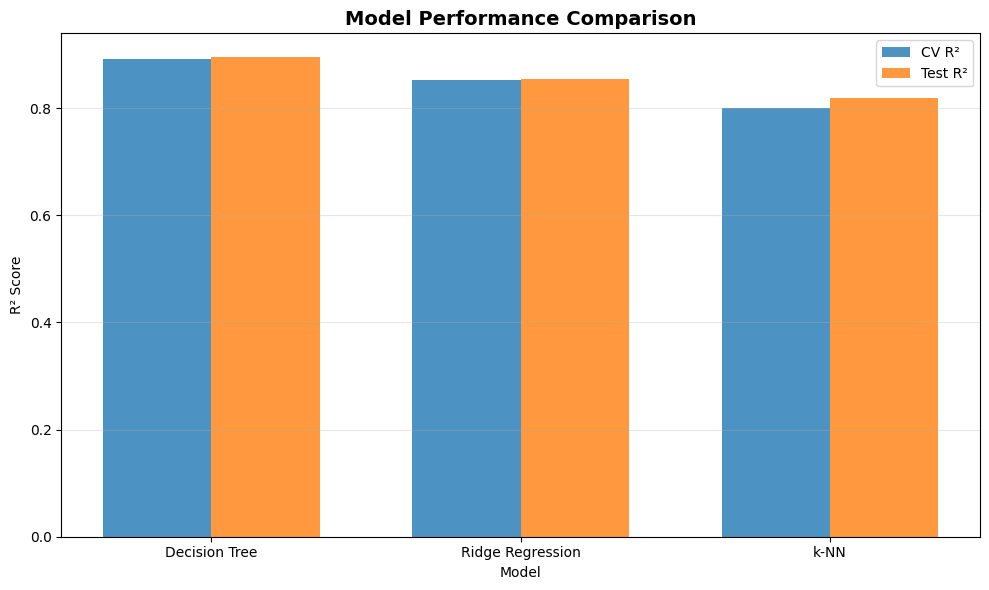

In [454]:
comparison = pd.DataFrame({
    'Model': ['Ridge Regression', 'Decision Tree', 'k-NN'],
    'Best_Params': [
        f"alpha={ridge_grid.best_params_['alpha']}",
        f"depth={dt_grid.best_params_['max_depth']}, split={dt_grid.best_params_['min_samples_split']}",
        f"k={knn_grid.best_params_['n_neighbors']}, {knn_grid.best_params_['weights']}, {knn_grid.best_params_['metric']}"
    ],
    'CV_R2': [ridge_grid.best_score_, dt_grid.best_score_, knn_grid.best_score_],
    'Test_R2': [test_r2_ridge, test_r2_dt, test_r2_knn]
})

comparison = comparison.sort_values('Test_R2', ascending=False)
print("\n" + comparison.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison))
width = 0.35

ax.bar(x - width/2, comparison['CV_R2'], width, label='CV R²', alpha=0.8)
ax.bar(x + width/2, comparison['Test_R2'], width, label='Test R²', alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Train Model

In [455]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [456]:
final_model = DecisionTreeRegressor(
    max_depth=20,
    min_samples_leaf=10,
    min_samples_split=50,
    random_state=42,
)

In [457]:
sample_weights_full = df['brand_prestige'].map({
    1: 1.0,
    2: 1.0,
    3: 1.0,   # No boost for luxury (28k is enough data)
    4: 1.0,   # Focus here - ultra-luxury
    5: 1.0
})

# Fit the model
final_model.fit(X_train_scaled, y_train,sample_weight=sample_weights_full.loc[X_train.index])

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=50,
                      random_state=42)

In [458]:
y_pred_log = final_model.predict(X_test_scaled)

### Visualize Trainning Results

In [459]:
y_pred_log = final_model.predict(X_test_scaled)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_log)

y_pred_train_log = final_model.predict(X_train_scaled)
y_train_real = np.expm1(y_train)
y_pred_train_real = np.expm1(y_pred_train_log)

# SCORING
r2_final_log_test = r2_score(y_test, y_pred_log)
r2_final_real_test = r2_score(y_test_real, y_pred_real)
mae_final_real_test = mean_absolute_error(y_test_real, y_pred_real)

r2_final_log_train = r2_score(y_train, y_pred_train_log)
r2_final_real_train = r2_score(y_train_real, y_pred_train_real)
mae_final_real_train = mean_absolute_error(y_train_real, y_pred_train_real)

print(f"--- FINAL TEST RESULTS ---")
print(f"R2 Score (Log-transformed, Test): {r2_final_log_test:.4f}")
print(f"R2 Score (Real Prices, Test): {r2_final_real_test:.4f}")
print(f"MAE (Test): £{mae_final_real_test:.2f} (Average error per car in real prices)")

print(f"\n--- FINAL TRAIN RESULTS ---")
print(f"R2 Score (Log-transformed, Train): {r2_final_log_train:.4f}")
print(f"R2 Score (Real Prices, Train): {r2_final_real_train:.4f}")
print(f"MAE (Train): £{mae_final_real_train:.2f} (Average error per car in real prices)")

--- FINAL TEST RESULTS ---
R2 Score (Log-transformed, Test): 0.8948
R2 Score (Real Prices, Test): 0.8125
MAE (Test): £3341.01 (Average error per car in real prices)

--- FINAL TRAIN RESULTS ---
R2 Score (Log-transformed, Train): 0.9120
R2 Score (Real Prices, Train): 0.8344
MAE (Train): £3113.28 (Average error per car in real prices)


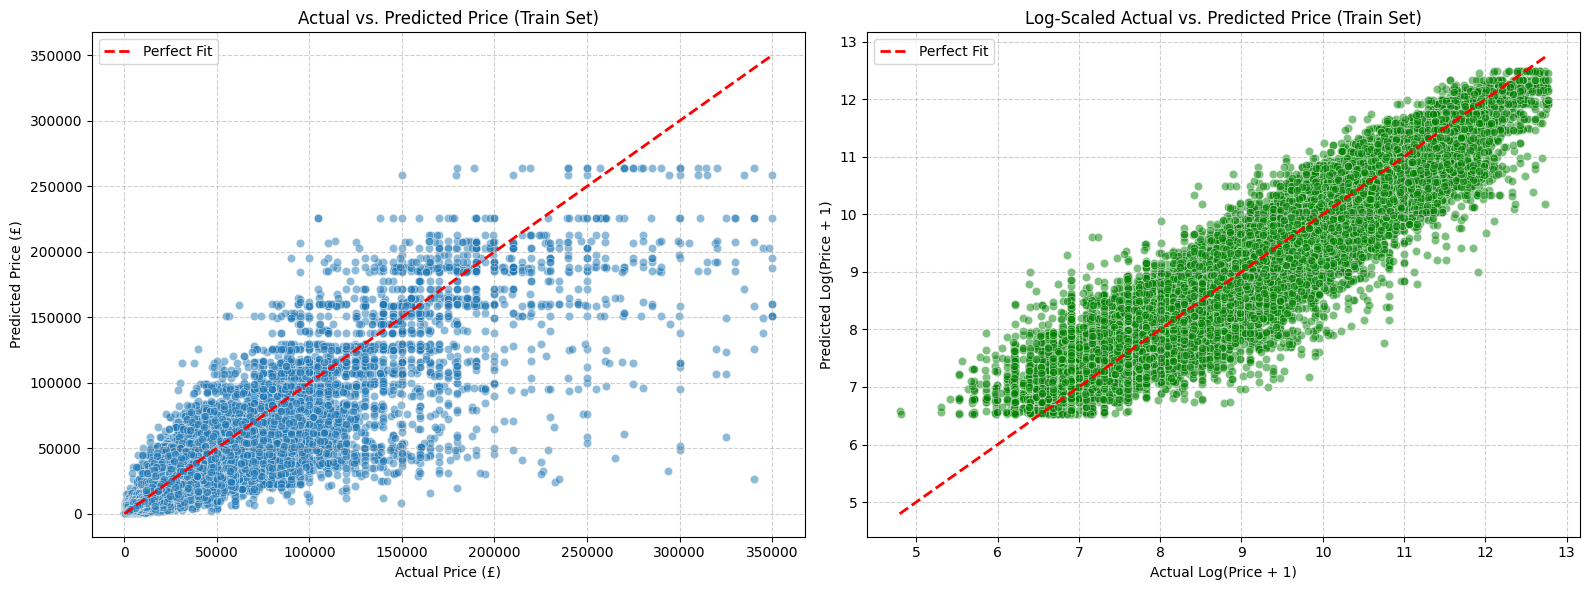

In [460]:
plt.figure(figsize=(16, 6))

# Plot 1: Actual vs. Predicted Price (Real Scale, Train Set)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_real, y=y_pred_train_real, alpha=0.5, color='#1f77b4')

min_val_real = min(y_train_real.min(), y_pred_train_real.min())
max_val_real = max(y_train_real.max(), y_pred_train_real.max())
plt.plot([min_val_real, max_val_real], [min_val_real, max_val_real], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Actual vs. Predicted Price (Train Set)')
plt.xlabel('Actual Price (£)')
plt.ylabel('Predicted Price (£)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Log-Scaled Actual vs. Predicted Price (Training Set)
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_train, y=y_pred_train_log, alpha=0.5, color='green')

min_val_log = min(y_train.min(), y_pred_train_log.min())
max_val_log = max(y_train.max(), y_pred_train_log.max())
plt.plot([min_val_log, max_val_log], [min_val_log, max_val_log], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title('Log-Scaled Actual vs. Predicted Price (Train Set)')
plt.xlabel('Actual Log(Price + 1)')
plt.ylabel('Predicted Log(Price + 1)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

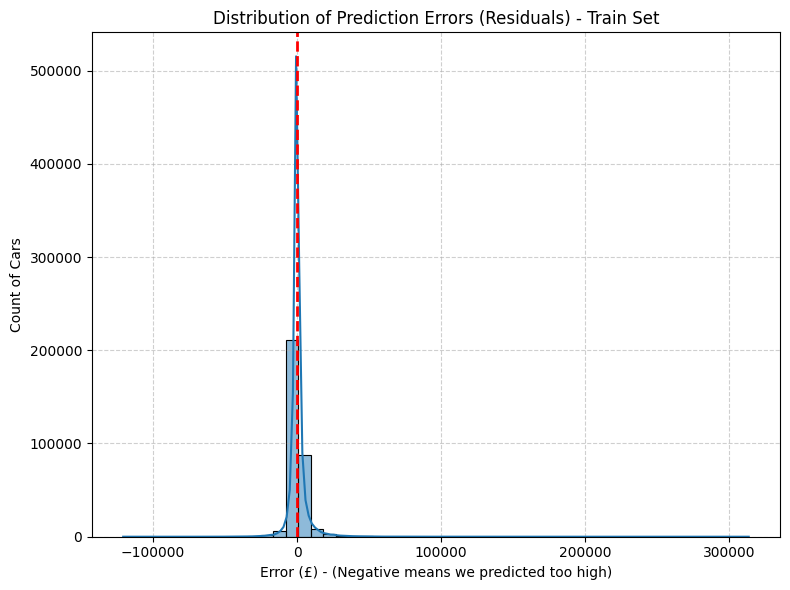

In [461]:
residuals_train = y_train_real - y_pred_train_real

plt.figure(figsize=(8, 6))
sns.histplot(residuals_train, kde=True, color='#1f77b4', bins=50)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.title('Distribution of Prediction Errors (Residuals) - Train Set')
plt.xlabel('Error (£) - (Negative means we predicted too high)')
plt.ylabel('Count of Cars')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

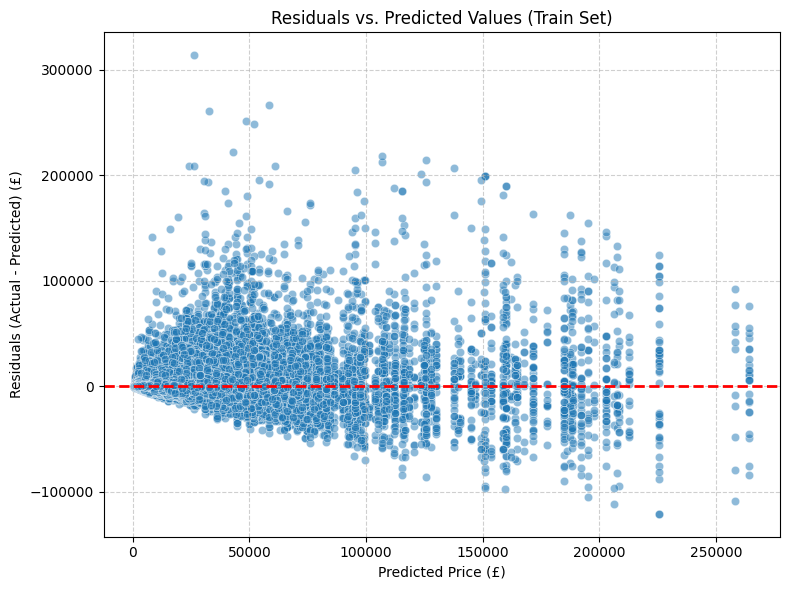

In [462]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_train_real, y=residuals_train, alpha=0.5, color='#1f77b4')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

plt.title('Residuals vs. Predicted Values (Train Set)')
plt.xlabel('Predicted Price (£)')
plt.ylabel('Residuals (Actual - Predicted) (£)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

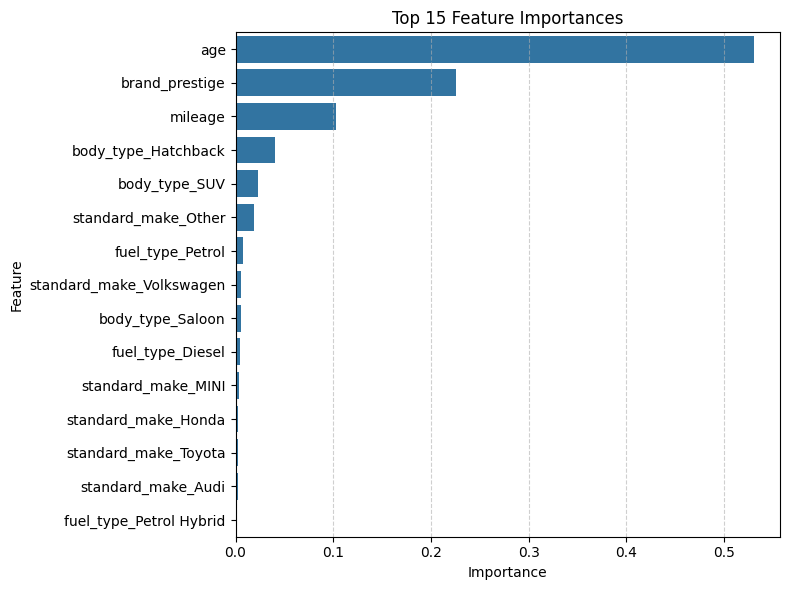

In [463]:
feature_names = X_train_scaled.columns
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), color='#1f77b4') # Top 15 features
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [464]:
# 1. Create a DataFrame of Actual vs Predicted
results_df = pd.DataFrame({
    'Actual_Price': y_test_real,
    'Predicted_Price': y_pred_real
})

# 2. Calculate the Absolute Error
results_df['Error'] = np.abs(results_df['Actual_Price'] - results_df['Predicted_Price'])

# 3. Sort by biggest error
worst_failures = results_df.sort_values(by='Error', ascending=False).head(10)

print("--- Top 5 Worst Model Failures ---")
print(worst_failures)

# Optional: If you still have the full X_test, join it to see the Car Brand/Year
# (Assuming indices match X_test_original if you have it, otherwise just analyze the prices)

--- Top 5 Worst Model Failures ---
        Actual_Price  Predicted_Price          Error
246904      349975.0    107718.868219  242256.131781
41659       274950.0     35942.782809  239007.217191
159014      329900.0     97936.405931  231963.594069
268102      249950.0     26422.050735  223527.949265
166945      345000.0    125775.702962  219224.297038
35911       259950.0     60385.281873  199564.718127
276353      325500.0    127884.260761  197615.739239
229190      225675.0     31430.853031  194244.146969
41641       250000.0     58585.588526  191414.411474
398009      349990.0    158941.314201  191048.685799
